In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt
from matplotlib.collections import BrokenBarHCollection, PolyCollection
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.path import Path
from matplotlib.ticker import FuncFormatter, NullFormatter

### External commands to prepare data

Align to HG38 with no alts, using minimap2

`parallel 'minimap2 -t 16 --secondary=no -ax map-ont /data/refs/hg38.p14.simple.mmi {} > {.}.paf' ::: *.fastq.gz`

Mosdepth the data
`parallel 'mosdepth -t 16 {.} {}' ::: *.bam`

There are two included shell scripts, the first will partition the modsepth files into contigs, the second will xzip compress them
1. `partition_contigs_from_mosdepths.sh`
1. `xzip_bed_files.sh`


### In order to monatge the images together use imgmagick

After running the notebook
https://imagemagick.org/script/download.php

```magick montage A_BRCA1.png D_BRCA1.png B_PML.png E_PML.png C_RARA.png F_RARA.png -tile 2x3 -geometry +0+0 figure_3.png```


In [4]:
colour_lookup = {
    "gneg": (1.0, 1.0, 1.0),
    "gpos25": (0.6, 0.6, 0.6),
    "gpos50": (0.4, 0.4, 0.4),
    "gpos75": (0.2, 0.2, 0.2),
    "gpos100": (0.0, 0.0, 0.0),
    # 'acen': (.8, .4, .4),
    # Set acen to be white as we use a
    #   polygon to add it in later
    "acen": (1.0, 1.0, 1.0),
    "gvar": (0.8, 0.8, 0.8),
    "stalk": (0.9, 0.9, 0.9),
}

In [5]:
cytobands = pd.read_csv(
    "https://hgdownload.cse.ucsc.edu/goldenpath/hg38/database/cytoBand.txt.gz",
    sep="\t",
    names=["chrom", "chromStart", "chromEnd", "name", "gieStain"],
)

In [6]:
cytobands["arm"] = cytobands["name"].str[0]
cytobands["colour"] = cytobands["gieStain"].map(colour_lookup)
cytobands["width"] = cytobands["chromEnd"] - cytobands["chromStart"]

In [7]:
def set_xmargin(ax, left=0.1, right=0.0):
    # https://stackoverflow.com/a/49382894
    ax.set_xmargin(0)
    ax.autoscale_view()
    lim = ax.get_xlim()
    delta = np.diff(lim)
    left = lim[0] - delta * left
    right = lim[1] + delta * right
    ax.set_xlim(left, right)


def set_ymargin(ax, top=0.1, bottom=0.0):
    # https://stackoverflow.com/a/49382894
    ax.set_ymargin(0)
    ax.autoscale_view()
    lim = ax.get_ylim()
    delta = np.diff(lim)
    bottom = lim[0] - delta * bottom
    top = lim[1] + delta * top
    ax.set_ylim(bottom, top)

In [8]:
def human_readable_yield(num: int, factor: int = 1000, suffix: str = "B") -> str:
    """Return a human readable string of a large number using SI unit prefixes

    Parameters
    ----------
    num : int
        A number to convert to decimal form
    factor : int
        The SI factor, use 1000 for SI units and 1024 for binary multiples
    suffix : str
        The suffix to place after the SI prefix, for example use B for SI units and iB for binary multiples

    Returns
    -------
    str
        Returns the input number formatted to two decimal places with the SI unit and suffix
    """
    for unit in ["", "k", "M", "G", "T", "P", "E", "Z"]:
        if abs(num) < factor:
            return "{n:3.2f} {u}{s}".format(n=num, u=unit, s=suffix)
        num /= factor
    return "{n:3.2f} {u}{s}".format(n=num, u="Y", s=suffix)

In [9]:
@FuncFormatter
def format_genomics_lengths(x, pos):
    return f"{human_readable_yield(x)}"

In [10]:
def plot_ideogram(
    ax,
    cytobands_df,
    target,
    start=None,
    stop=None,
    lower_anchor=0,
    height=1,
    curve=0.01,
    y_margin=0.25,
    right_margin=0.005,
    #     bottom_margin=.25,
    left_margin=0.25,
    target_region_extent=0.3,
):
    # TODO: various kwds params for passing through to other methods
    df = cytobands_df[cytobands_df["chrom"].eq(target)]
    yrange = (lower_anchor, height)  # lower anchor, height
    ymid = (max(yrange) - min(yrange)) / 2
    xrange = df[["chromStart", "width"]].values
    chr_len = df["chromEnd"].max()

    # Stain lines
    bars = BrokenBarHCollection(xrange, yrange, facecolors=df["colour"])
    ax.add_collection(bars)

    # Centromere
    cen_df = df[df["gieStain"].str.contains("cen")]
    cen_start = cen_df["chromStart"].min()
    cen_end = cen_df["chromEnd"].max()

    cen_poly = [
        (cen_start, lower_anchor),
        (cen_start, height),
        (cen_end, lower_anchor),
        (cen_end, height),
    ]
    cen_patch = PathPatch(Path(cen_poly), facecolor=(0.8, 0.4, 0.4), lw=0)
    ax.add_patch(cen_patch)
    # Chromosome outline polygon
    chr_move, chr_poly = zip(
        *[
            (Path.MOVETO, (lower_anchor, height)),
            # Top left, bottom right: ‾\_
            (Path.LINETO, (cen_start, height)),
            (Path.LINETO, (cen_end, lower_anchor)),
            (Path.LINETO, (chr_len, lower_anchor)),
            # Right telomere: )
            (Path.LINETO, (chr_len, lower_anchor)),
            (Path.CURVE3, (chr_len + chr_len * curve, ymid)),
            (Path.LINETO, (chr_len, height)),
            # Top right, bottom left: _/‾
            (Path.LINETO, (cen_end, height)),
            (Path.LINETO, (cen_start, lower_anchor)),
            (Path.LINETO, (lower_anchor, lower_anchor)),
            # Left telomere: (
            (Path.CURVE3, (lower_anchor - chr_len * curve, ymid)),
            (Path.LINETO, (lower_anchor, height)),
            (Path.CLOSEPOLY, (lower_anchor, height)),
        ]
    )

    chr_patch = PathPatch(Path(chr_poly, chr_move), fill=None, joinstyle="round")
    ax.add_patch(chr_patch)

    if start is not None and stop is not None:
        r = Rectangle(
            (start, lower_anchor - target_region_extent),
            width=stop - start,
            height=height + 2 * target_region_extent,
            fill=False,
            edgecolor="r",
            linewidth=1,
            joinstyle="round",
        )
        ax.add_patch(r)

    set_xmargin(ax, left=left_margin, right=right_margin)
    # set_ymargin(ax, top=top_margin, bottom=bottom_margin)
    ax.set_ymargin(y_margin)

    # Remove bounds and make tidy
    for side in ("top", "right", "bottom", "left"):
        ax.spines[side].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)

    x0, x1 = ax.get_xlim()
    name = f"Chromosome {target.lstrip('chr')}"
    ax.text(x0, ymid, name, fontsize="x-large", va="center")
    return ax

In [11]:
def plot_scale(ax, start, stop, scale_loc=0.1, length_loc=0.75):
    ax.set_xlim(start, stop)
    ax.yaxis.set_visible(False)
    ax.set_ylim(0, 1)
    for side in ("right", "top", "left"):
        ax.spines[side].set_visible(False)
    ax.set_xlim(start, stop)
    ax.spines.bottom.set_position(("axes", scale_loc))

    scale = stop - start
    mid_point = start + scale / 2

    for point in (start, stop):
        ann = ax.annotate(
            f"{human_readable_yield(scale)}",
            xytext=(mid_point, length_loc),
            xycoords="data",
            xy=(point, length_loc),
            textcoords="data",
            size="x-large",
            va="center",
            ha="center",
            arrowprops={"arrowstyle": "-|>", "facecolor": "black"},
        )

    ax.xaxis.set_major_formatter(format_genomics_lengths)
    return ax

In [13]:
bed01 = pd.read_csv(
    "files/merge_tst_170_coords_extended.bed.xz",
    sep="\t",
    names=["chromosome", "start", "end"],
)
bed02 = pd.read_csv(
    "files/merge_tst_fusion_coords_extended.bed.xz",
    sep="\t",
    names=["chromosome", "start", "end"],
)
bed03 = pd.read_csv(
    "files/merge_CancerPanelTargets.bed.xz",
    sep="\t",
    names=["chromosome", "start", "end"],
)

In [14]:
BASE_PATH = "files/{}.{}.{}.per-base.bed.xz"


def read_data(chromosome, barcode, subset):
    return pd.read_csv(
        BASE_PATH.format(chromosome, barcode, subset),
        sep="\t",
        names=["chromosome", "start", "end", "value"],
    )

In [15]:
def plot_coverage(
    ax, df, target, start, stop, ylabel, top_margin=0.1, bottom_margin=0, **kwargs
):
    df = df[df["chromosome"].eq(target) & df["start"].ge(start) & df["end"].le(stop)]
    ax.fill_between(
        df["start"],
        df["value"],
        step="post",
        **kwargs,
    )

    ax.xaxis.set_major_formatter(NullFormatter())
    ax.xaxis.set_tick_params(length=0)
    set_ymargin(ax, top=top_margin, bottom=bottom_margin)
    ax.grid(True, which="both", axis="both")
    ax.set_ylabel(ylabel, size="x-large")
    ax.yaxis.set_tick_params(labelsize="x-large")
    return ax

In [16]:
def plot_bed_regions(ax, df, target, start, stop):
    df = df[
        df["chromosome"].eq(target)
        & (df["start"].between(start, stop) | df["end"].between(start, stop))
    ]
    ylim = ax.get_ylim()
    for _, start_, stop_ in df.itertuples(False):
        r = Rectangle(
            (start_, min(ylim)),
            width=stop_ - start_,
            height=max(ylim),
            fill=True,
        )
        ax.add_patch(r)

    for side in ("right", "top", "left", "bottom"):
        ax.spines[side].set_visible(False)
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    return ax

In [17]:
def presenterise(barcode: str) -> str:
    """
    Take a one word barcode string - eg. barcode01 and convert it to presentation mode
    i.e Barcode 01
    """
    number = barcode[-2:]
    return f"Barcode {number}"

/tmp/ipykernel_605126/3935392621.py:42: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  share_x[0].get_shared_x_axes().join(*share_x)
/tmp/ipykernel_605126/1344962263.py:24: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  bars = BrokenBarHCollection(xrange, yrange, facecolors=df["colour"])
/tmp/ipykernel_605126/3935392621.py:42: MatplotlibDeprecationWarning: The join function was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  share_x[0].get_shared_x_axes().join(*share_x)
/tmp/ipykernel_605126/1344962263.py:24: MatplotlibDeprecationWarning: The BrokenBarHCollection class was deprecated in Matplotlib 3.7 and will be removed two minor releases later.
  bars = BrokenBarHCollection(xrange, yrange, facecolors=df["colour"])
/tmp/ipykernel_605126/3935392621.py:42: MatplotlibDeprecationWarning

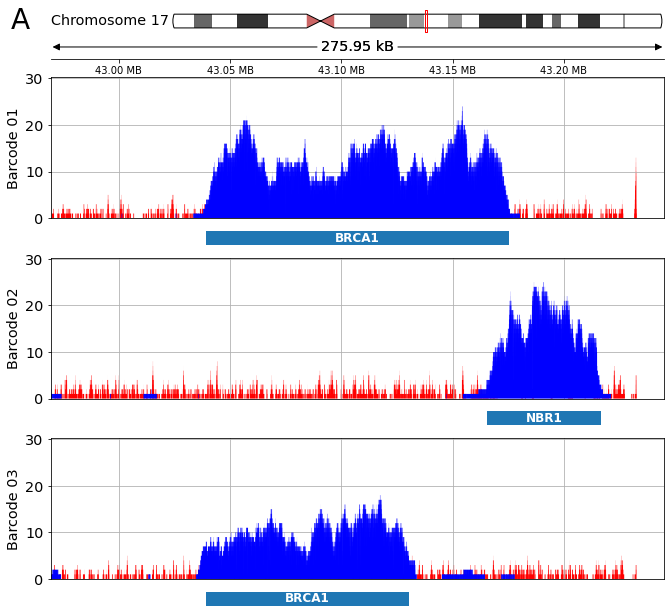

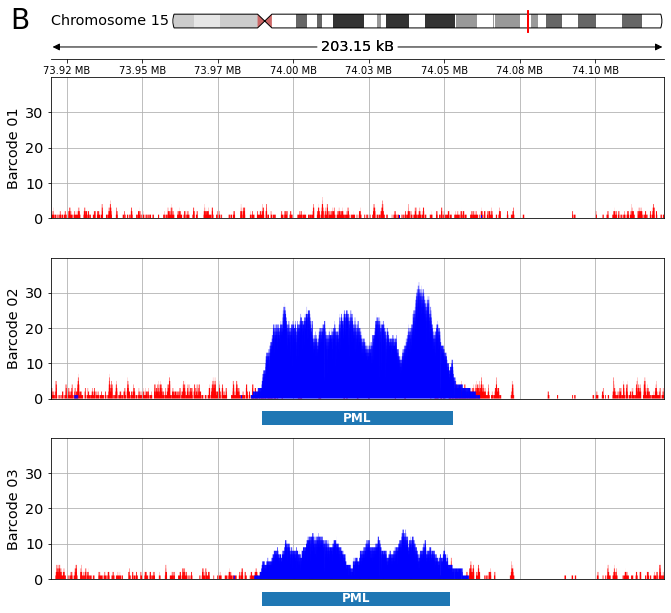

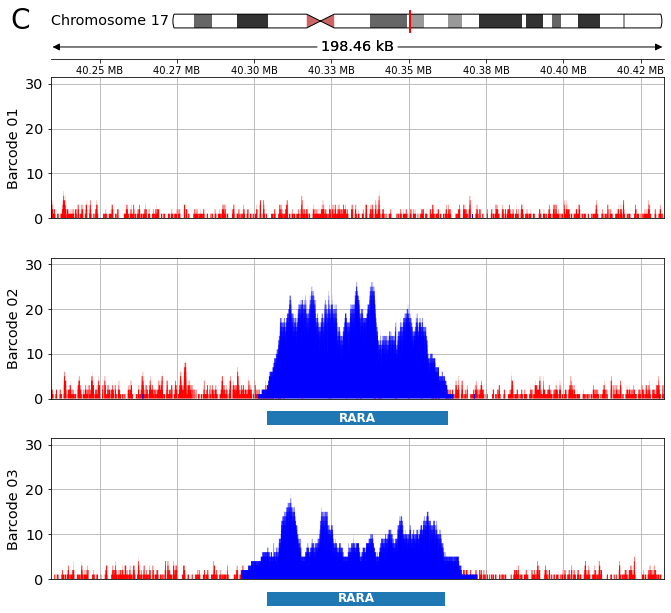

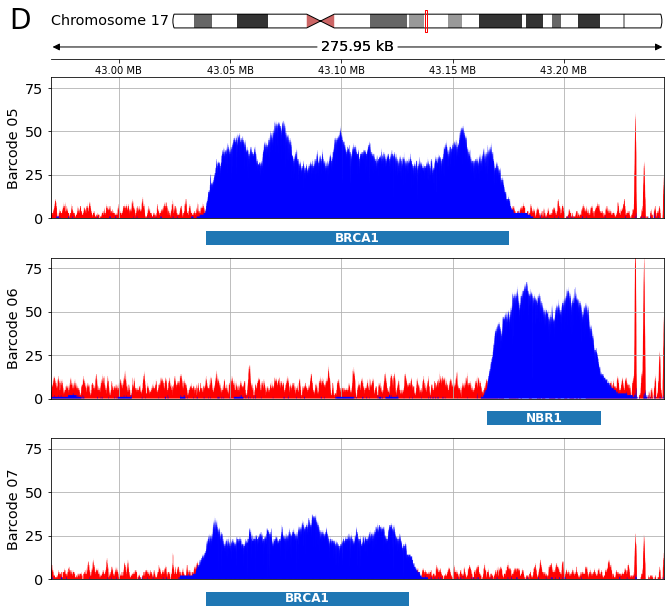

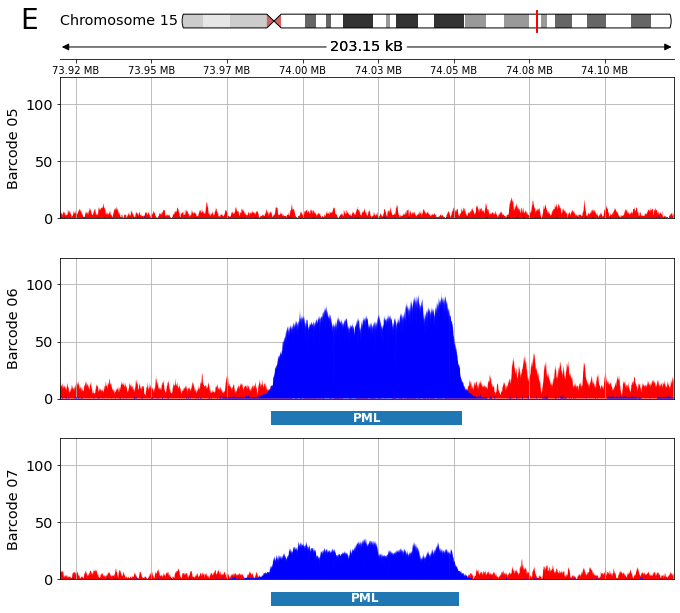

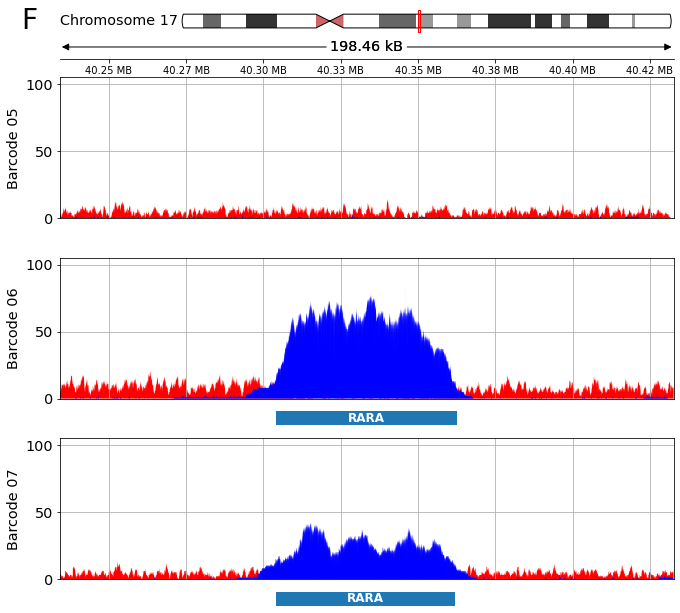

In [19]:
targets = (
    ("A", "BRCA1", "17:43044295-43170245"),
    ("B", "PML", "15:73994673-74047827"),
    ("C", "RARA", "17:40309180-40357643"),
    ("D", "BRCA1", "17:43044295-43170245"),
    ("E", "PML", "15:73994673-74047827"),
    ("F", "RARA", "17:40309180-40357643"),
)
barcodes = (
    ("barcode01", "barcode02", "barcode03"),
    ("barcode05", "barcode06", "barcode07"),
)
window = 75_000

seq_kwds = {"fc": "blue", "lw": 0, "zorder": 2}
unb_kwds = {"fc": "red", "lw": 0, "zorder": 1}
for letter, name, s in targets:
    target, coords = s.split(":")
    target = f"chr{target}"
    start, stop = map(int, coords.split("-"))
    start = start - window
    stop = stop + window

    barcode_index = 0 if ord(letter) < 68 else 1
    bc1, bc2, bc3 = barcodes[barcode_index]
    bc01_seq = read_data(target, bc1, "sequenced")
    bc01_unb = read_data(target, bc1, "unblocked")
    bc02_seq = read_data(target, bc2, "sequenced")
    bc02_unb = read_data(target, bc2, "unblocked")
    bc03_seq = read_data(target, bc3, "sequenced")
    bc03_unb = read_data(target, bc3, "unblocked")

    # Begin plotting
    fig, (ideogram_ax, scale_ax, cax0, bax0, cax1, bax1, cax2, bax2) = plt.subplots(
        ncols=1,
        nrows=8,
        figsize=(11, 11),
        gridspec_kw={"height_ratios": [1.5, 1, 8, 0.8, 8, 0.8, 8, 0.8]},
        facecolor="white",
    )
    share_x = [scale_ax, cax0, cax1, cax2, bax0, bax1, bax2]
    share_x[0].get_shared_x_axes().join(*share_x)

    plot_ideogram(
        ideogram_ax,
        cytobands,
        target=target,
        start=start,
        stop=stop,
        curve=0.005,
        y_margin=0.1,
    )
    ideogram_ax.text(
        -0.05,
        0.5,
        letter,
        fontsize=28,
        horizontalalignment="center",
        verticalalignment="center",
        transform=ideogram_ax.transAxes,
    )
    plot_scale(scale_ax, start, stop, 0.3, 1)

    plot_coverage(cax0, bc01_seq, target, start, stop, "", **seq_kwds)
    plot_coverage(cax0, bc01_unb, target, start, stop, presenterise(bc1), **unb_kwds)
    plot_coverage(cax1, bc02_seq, target, start, stop, "", **seq_kwds)
    plot_coverage(cax1, bc02_unb, target, start, stop, presenterise(bc2), **unb_kwds)
    plot_coverage(cax2, bc03_seq, target, start, stop, "", **seq_kwds)
    plot_coverage(cax2, bc03_unb, target, start, stop, presenterise(bc3), **unb_kwds)
    # Fix ylim on coverage axes
    share_y = sorted(
        [cax0, cax1, cax2], key=lambda ax: max(ax.get_ylim()), reverse=True
    )
    ylim = share_y[0].get_ylim()
    for ax in share_y:
        ax.set_ylim(ylim)

    for i, (ax, df) in enumerate(zip([bax0, bax1, bax2], [bed01, bed02, bed03])):
        plot_bed_regions(ax, df, target, start, stop)
        # Add target name to the bed-track
        # This little bit is custom here:
        for p in ax.patches:
            n = "NBR1" if name == "BRCA1" and i == 1 else name
            rx, ry = p.get_xy()
            cx = rx + p.get_width() / 2.0
            cy = ry + p.get_height() / 2.0
            ax.annotate(
                n,
                (cx, cy),
                color="w",
                weight="bold",
                fontsize="large",
                ha="center",
                va="center",
            )

    # fig.suptitle(name)
    fig.savefig(f"{letter}_{name}.png", dpi=300, bbox_inches="tight")
    fig.savefig(f"{letter}_{name}.pdf", bbox_inches="tight")
    fig.savefig(f"{letter}_{name}.tiff", dpi=300, bbox_inches="tight")
    fig.savefig(f"{letter}_{name}.eps", dpi=300, bbox_inches="tight")